In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

2025-10-26 14:06:13.588988: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 14:06:13.616035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 14:06:13.616062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 14:06:13.616758: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 14:06:13.621648: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import platform
import psutil

print("=" * 50)
print("MACHINE SPECIFICATIONS")
print("=" * 50)
print(f"OS: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")
print(f"TensorFlow Version: {tf.__version__}")
print(f"GPUs Available: {tf.config.list_physical_devices('GPU')}")
print("=" * 50)

MACHINE SPECIFICATIONS
OS: Linux 6.6.87.2-microsoft-standard-WSL2
Processor: x86_64
RAM: 11.68 GB
TensorFlow Version: 2.15.0
GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-10-26 14:06:14.639985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 14:06:14.684099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 14:06:14.684150: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
class Config:
    """Configuration for MobileNetV2 training"""
    DATASET_NAME = 'indoor-plant-disease-dataset-23-classes/dataset_flat_structure'
    # !kaggle datasets download -d {DATASET_NAME} --unzip
    DATASET_PATH = Path('dataset_flat_structure')
    TRAIN_DIR = os.path.join(DATASET_PATH, 'train')
    VAL_DIR = os.path.join(DATASET_PATH, 'validation')
    TEST_DIR = os.path.join(DATASET_PATH, 'test')
    
    # Model parameters
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    NUM_CLASSES = 23
    
    # Phase 1: Feature extraction
    PHASE1_EPOCHS = 30 
    PHASE1_LR = 0.001
    PHASE1_FREEZE_BASE = True
    
    # Phase 2: Fine-tuning
    PHASE2_EPOCHS = 20
    PHASE2_LR = 0.00001
    UNFREEZE_LAYERS = 30
    
    # Early stopping
    EARLY_STOP_PATIENCE = 10
    REDUCE_LR_PATIENCE = 5 
    REDUCE_LR_FACTOR = 0.5
    MIN_LR = 1e-7
    
    # Output
    OUTPUT_DIR = 'output'
    MODEL_NAME = 'mobilenetv2_plant_disease'

In [4]:
config = Config()

# Create directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(config.OUTPUT_DIR, 'models'), exist_ok=True)
os.makedirs(os.path.join(config.OUTPUT_DIR, 'plots'), exist_ok=True)
os.makedirs(os.path.join(config.OUTPUT_DIR, 'metrics'), exist_ok=True)

In [5]:
print("=" * 80)
print("MOBILENETV2 PLANT DISEASE DETECTION")
print("=" * 80)
print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {len(tf.config.list_physical_devices('GPU'))} available")
print(f"Dataset: {config.DATASET_PATH}")
print(f"Output: {config.OUTPUT_DIR}")
print("=" * 80)

MOBILENETV2 PLANT DISEASE DETECTION
TensorFlow: 2.15.0
GPU: 1 available
Dataset: dataset_flat_structure
Output: output


In [6]:
# Verify paths
assert os.path.exists(config.DATASET_PATH), f"Dataset not found at {config.DATASET_PATH}"
assert os.path.exists(config.TRAIN_DIR), f"Train folder not found"
assert os.path.exists(config.VAL_DIR), f"Validation folder not found"
assert os.path.exists(config.TEST_DIR), f"Test folder not found"

print("\n✓ All paths verified!")


✓ All paths verified!


In [7]:
print("\n[1/8] Loading Data Generators...")

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    config.TRAIN_DIR,
    target_size=config.IMG_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    config.VAL_DIR,
    target_size=config.IMG_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    config.TEST_DIR,
    target_size=config.IMG_SIZE,
    batch_size=config.BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
idx_to_class = {v: k for k, v in class_indices.items()}

print(f"\n✓ Training: {train_generator.samples:,} samples")
print(f"✓ Validation: {val_generator.samples:,} samples")
print(f"✓ Test: {test_generator.samples:,} samples")
print(f"✓ Classes: {len(class_names)}")

with open(os.path.join(config.OUTPUT_DIR, 'class_mappings.json'), 'w') as f:
    json.dump({'class_indices': class_indices, 'class_names': class_names}, f, indent=4)


[1/8] Loading Data Generators...
Found 21523 images belonging to 23 classes.
Found 6149 images belonging to 23 classes.
Found 3076 images belonging to 23 classes.

✓ Training: 21,523 samples
✓ Validation: 6,149 samples
✓ Test: 3,076 samples
✓ Classes: 23


In [8]:
print("\n[2/8] Computing Class Weights...")

class_counts = {}
for class_name in class_names:
    class_dir = os.path.join(config.TRAIN_DIR, class_name)
    if os.path.exists(class_dir):
        class_counts[class_name] = len([f for f in os.listdir(class_dir) 
                                       if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

classes = np.array([class_indices[name] for name in class_counts.keys()])
counts = np.array(list(class_counts.values()))
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=np.repeat(classes, counts)
)
class_weights = dict(zip(classes, class_weights_array))

df_distribution = pd.DataFrame({
    'Class': class_counts.keys(),
    'Count': class_counts.values(),
    'Weight': [class_weights[class_indices[name]] for name in class_counts.keys()]
}).sort_values('Count')

print(f"\n✓ Imbalance Ratio: {df_distribution.iloc[-1]['Count'] / df_distribution.iloc[0]['Count']:.1f}:1")
print(f"✓ Weight Range: {min(class_weights.values()):.3f} - {max(class_weights.values()):.3f}")

df_distribution.to_csv(os.path.join(config.OUTPUT_DIR, 'metrics', 'class_distribution.csv'), index=False)

print("\n" + "=" * 80)
print("Data loaded and ready!")
print("=" * 80)


[2/8] Computing Class Weights...

✓ Imbalance Ratio: 47.8:1
✓ Weight Range: 0.242 - 11.553

Data loaded and ready!


In [9]:
print("\n[3/8] Building MobileNetV2 Model...")

def create_model(num_classes, input_shape=(224, 224, 3), freeze_base=True):
    """Create MobileNetV2 with custom head"""
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    
    base_model.trainable = not freeze_base
    
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=not freeze_base)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs, name='MobileNetV2_PlantDisease')
    return model, base_model

model, base_model = create_model(config.NUM_CLASSES, freeze_base=config.PHASE1_FREEZE_BASE)

trainable_params_phase1 = sum([tf.size(w).numpy() for w in model.trainable_weights])
total_params = model.count_params()

print(f"\n✓ Model Created:")
print(f"  Total params: {total_params:,}")
print(f"  Trainable (Phase 1): {trainable_params_phase1:,}")
print(f"  Base layers: {len(base_model.layers)}")

def get_callbacks(phase):
    """Enhanced callbacks with aggressive early stopping"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    callbacks = [
        ModelCheckpoint(
            filepath=os.path.join(config.OUTPUT_DIR, 'models', 
                                 f'{config.MODEL_NAME}_phase{phase}_best.keras'),
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=config.EARLY_STOP_PATIENCE,
            restore_best_weights=True,
            verbose=1,
            mode='min'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=config.REDUCE_LR_FACTOR,
            patience=config.REDUCE_LR_PATIENCE,
            min_lr=config.MIN_LR,
            verbose=1,
            mode='min'
        ),
        CSVLogger(
            os.path.join(config.OUTPUT_DIR, 'metrics', 
                        f'training_log_phase{phase}_{timestamp}.csv')
        )
    ]
    
    return callbacks

print("\n✓ Callbacks configured (Early stopping enabled)")
print("=" * 80)
print("Model ready for training!")
print("=" * 80)


[3/8] Building MobileNetV2 Model...


2025-10-26 14:06:14.059914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 14:06:14.060028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 14:06:14.060048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 14:06:14.203926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-26 14:06:14.204047: I external/local_xla/xla/stream_executor

9406464/9406464 [==============================] - 1s 0us/step

✓ Model Created:
  Total params: 2,597,975
  Trainable (Phase 1): 336,919
  Base layers: 155

✓ Callbacks configured (Early stopping enabled)
Model ready for training!


In [10]:
print("\n" + "=" * 80)
print("🔵 PHASE 1: FEATURE EXTRACTION")
print("=" * 80)
print(f"Max epochs: {config.PHASE1_EPOCHS} (Early stop patience: {config.EARLY_STOP_PATIENCE})")
print(f"Learning rate: {config.PHASE1_LR}")
print("=" * 80)

model.compile(
    optimizer=optimizers.Adam(learning_rate=config.PHASE1_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print("\n[4/8] Training Phase 1...")
history_phase1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.PHASE1_EPOCHS,
    class_weight=class_weights,
    callbacks=get_callbacks(phase=1),
    verbose=1
)

with open(os.path.join(config.OUTPUT_DIR, 'metrics', 'history_phase1.json'), 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history_phase1.history.items()}, f, indent=4)

best_val_loss_p1 = min(history_phase1.history['val_loss'])
best_val_acc_p1 = max(history_phase1.history['val_accuracy'])
actual_epochs_p1 = len(history_phase1.history['loss'])

print(f"\n✓ Phase 1 Complete!")
print(f"  Actual epochs: {actual_epochs_p1} (max: {config.PHASE1_EPOCHS})")
print(f"  Best val_loss: {best_val_loss_p1:.4f}")
print(f"  Best val_acc: {best_val_acc_p1:.4f}")


🔵 PHASE 1: FEATURE EXTRACTION
Max epochs: 30 (Early stop patience: 10)
Learning rate: 0.001

[4/8] Training Phase 1...
Epoch 1/30


2025-10-26 14:06:22.086296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-10-26 14:06:23.830962: I external/local_xla/xla/service/service.cc:168] XLA service 0x749e651c2610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-26 14:06:23.831004: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-10-26 14:06:23.857344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761476784.002326    2571 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


673/673 [==============================] - ETA: 0s - loss: 0.8611 - accuracy: 0.8451 - top3_accuracy: 0.9643
Epoch 1: val_loss improved from inf to 0.52850, saving model to output/models/mobilenetv2_plant_disease_phase1_best.keras
673/673 [==============================] - 121s 174ms/step - loss: 0.8611 - accuracy: 0.8451 - top3_accuracy: 0.9643 - val_loss: 0.5285 - val_accuracy: 0.9572 - val_top3_accuracy: 0.9989 - lr: 0.0010
Epoch 2/30
673/673 [==============================] - ETA: 0s - loss: 0.5780 - accuracy: 0.9175 - top3_accuracy: 0.9934
Epoch 2: val_loss improved from 0.52850 to 0.44220, saving model to output/models/mobilenetv2_plant_disease_phase1_best.keras
673/673 [==============================] - 111s 165ms/step - loss: 0.5780 - accuracy: 0.9175 - top3_accuracy: 0.9934 - val_loss: 0.4422 - val_accuracy: 0.9603 - val_top3_accuracy: 1.0000 - lr: 0.0010
Epoch 3/30
673/673 [==============================] - ETA: 0s - loss: 0.4739 - accuracy: 0.9298 - top3_accuracy: 0.9960
Epo

In [11]:
print("\n" + "=" * 80)
print("🟢 PHASE 2: FINE-TUNING")
print("=" * 80)

base_model.trainable = True
total_layers = len(base_model.layers)
freeze_until = total_layers - config.UNFREEZE_LAYERS

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False

trainable_params_phase2 = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"Unfrozen layers: {config.UNFREEZE_LAYERS}/{total_layers}")
print(f"Trainable params: {trainable_params_phase2:,}")
print(f"Max epochs: {config.PHASE2_EPOCHS} (Early stop patience: {config.EARLY_STOP_PATIENCE})")
print(f"Learning rate: {config.PHASE2_LR}")
print("=" * 80)

model.compile(
    optimizer=optimizers.Adam(learning_rate=config.PHASE2_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top3_accuracy')]
)

print("\n[5/8] Training Phase 2...")
history_phase2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.PHASE2_EPOCHS,
    class_weight=class_weights,
    callbacks=get_callbacks(phase=2),
    verbose=1
)

with open(os.path.join(config.OUTPUT_DIR, 'metrics', 'history_phase2.json'), 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history_phase2.history.items()}, f, indent=4)

best_val_loss_p2 = min(history_phase2.history['val_loss'])
best_val_acc_p2 = max(history_phase2.history['val_accuracy'])
actual_epochs_p2 = len(history_phase2.history['loss'])

print(f"\n✓ Phase 2 Complete!")
print(f"  Actual epochs: {actual_epochs_p2} (max: {config.PHASE2_EPOCHS})")
print(f"  Best val_loss: {best_val_loss_p2:.4f}")
print(f"  Best val_acc: {best_val_acc_p2:.4f}")

final_model_path = os.path.join(config.OUTPUT_DIR, 'models', f'{config.MODEL_NAME}_final.keras')
model.save(final_model_path)

print("\n" + "=" * 80)
print("✅ TRAINING COMPLETE!")
print("=" * 80)
print(f"Total epochs: {actual_epochs_p1 + actual_epochs_p2}")
print(f"Final model saved: {final_model_path}")
print("=" * 80)


🟢 PHASE 2: FINE-TUNING
Unfrozen layers: 30/155
Trainable params: 1,862,999
Max epochs: 20 (Early stop patience: 10)
Learning rate: 1e-05

[5/8] Training Phase 2...
Epoch 1/20
673/673 [==============================] - ETA: 0s - loss: 0.1582 - accuracy: 0.9676 - top3_accuracy: 0.9994
Epoch 1: val_loss improved from inf to 0.14237, saving model to output/models/mobilenetv2_plant_disease_phase2_best.keras
673/673 [==============================] - 118s 163ms/step - loss: 0.1582 - accuracy: 0.9676 - top3_accuracy: 0.9994 - val_loss: 0.1424 - val_accuracy: 0.9819 - val_top3_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 2/20
673/673 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9707 - top3_accuracy: 0.9997
Epoch 2: val_loss improved from 0.14237 to 0.13332, saving model to output/models/mobilenetv2_plant_disease_phase2_best.keras
673/673 [==============================] - 114s 169ms/step - loss: 0.1499 - accuracy: 0.9707 - top3_accuracy: 0.9997 - val_loss: 0.1333 - val_a

In [12]:
# ==================== RELOAD VARIABLES IF NEEDED ====================
print("Checking required variables...")

# Check if variables exist, if not, reload them
try:
    test_generator
    print("✓ test_generator found")
except NameError:
    print("⚠️ test_generator not found - reloading from Cell 1...")
    
    # Re-import necessary libraries
    import os
    import numpy as np
    import pandas as pd
    import json
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
    
    # Reload config
    class Config:
        DATASET_NAME = 'indoor-plant-disease-dataset-23-classes/dataset_flat_structure'
        # !kaggle datasets download -d {DATASET_NAME} --unzip
        DATASET_PATH = Path('dataset_flat_structure')
        TEST_DIR = os.path.join(DATASET_PATH, 'test')
        IMG_SIZE = (224, 224)
        BATCH_SIZE = 32
        NUM_CLASSES = 23
        OUTPUT_DIR = 'output'
    
    config = Config()
    
    # Reload test generator
    val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = val_test_datagen.flow_from_directory(
        config.TEST_DIR,
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # Reload class mappings
    with open(os.path.join(config.OUTPUT_DIR, 'class_mappings.json'), 'r') as f:
        mappings = json.load(f)
        class_indices = mappings['class_indices']
        class_names = mappings['class_names']
        idx_to_class = {v: k for k, v in class_indices.items()}
    
    print("✓ Variables reloaded successfully")

try:
    model
    print("✓ model found")
except NameError:
    print("⚠️ model not found - loading from saved file...")
    from tensorflow import keras
    model = keras.models.load_model(
        os.path.join(config.OUTPUT_DIR, 'models', 'mobilenetv2_plant_disease_final.keras')
    )
    print("✓ Model loaded successfully")

try:
    total_params
    actual_epochs_p1
    actual_epochs_p2
    print("✓ Training metadata found")
except NameError:
    print("⚠️ Training metadata not found - extracting from model...")
    total_params = model.count_params()
    
    # Load training history to get actual epochs
    try:
        with open(os.path.join(config.OUTPUT_DIR, 'metrics', 'history_phase1.json'), 'r') as f:
            hist1 = json.load(f)
            actual_epochs_p1 = len(hist1['loss'])
        with open(os.path.join(config.OUTPUT_DIR, 'metrics', 'history_phase2.json'), 'r') as f:
            hist2 = json.load(f)
            actual_epochs_p2 = len(hist2['loss'])
        print(f"✓ Loaded: Phase1={actual_epochs_p1} epochs, Phase2={actual_epochs_p2} epochs")
    except:
        # Fallback values if history files don't exist yet
        actual_epochs_p1 = 0
        actual_epochs_p2 = 0
        print("⚠️ Could not load training history - using defaults")

Checking required variables...
✓ test_generator found
✓ model found
✓ Training metadata found


In [13]:
print("\n" + "=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

print("\n[6/8] Testing on held-out test set...")

test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

test_loss, test_accuracy, test_top3 = model.evaluate(test_generator, verbose=0)

print(f"\nTEST RESULTS:")
print(f"  Accuracy: {test_accuracy*100:.2f}%")
print(f"  Top-3 Accuracy: {test_top3*100:.2f}%")
print(f"  Loss: {test_loss:.4f}")


MODEL EVALUATION

[6/8] Testing on held-out test set...
97/97 [==============================] - 4s 33ms/step

TEST RESULTS:
  Accuracy: 99.09%
  Top-3 Accuracy: 100.00%
  Loss: 0.0998


In [14]:
# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

df_metrics = pd.DataFrame({
    'Class': [idx_to_class[i] for i in range(config.NUM_CLASSES)],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}).sort_values('F1-Score')

df_metrics.to_csv(os.path.join(config.OUTPUT_DIR, 'metrics', 'per_class_metrics.csv'), index=False)

In [15]:
# Macro and weighted averages
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print(f"\nMacro Averages (Unweighted):")
print(f"  Precision: {macro_precision:.4f}")
print(f"  Recall: {macro_recall:.4f}")
print(f"  F1-Score: {macro_f1:.4f}")

print(f"\nWeighted Averages:")
print(f"  Precision: {weighted_precision:.4f}")
print(f"  Recall: {weighted_recall:.4f}")
print(f"  F1-Score: {weighted_f1:.4f}")


Macro Averages (Unweighted):
  Precision: 0.9926
  Recall: 0.9937
  F1-Score: 0.9932

Weighted Averages:
  Precision: 0.9909
  Recall: 0.9909
  F1-Score: 0.9909


In [16]:
worst_10 = df_metrics.head(10)
best_10 = df_metrics.tail(10)

print(f"\n🔴 10 Worst Classes:")
for idx, row in worst_10.iterrows():
    print(f"  {row['Class'][:40]:40s} F1={row['F1-Score']:.3f}")

print(f"\n🟢 10 Best Classes:")
for idx, row in best_10.iterrows():
    print(f"  {row['Class'][:40]:40s} F1={row['F1-Score']:.3f}")


🔴 10 Worst Classes:
  Rose_Downy_Mildew                        F1=0.968
  Rose_Black_Spot                          F1=0.970
  Chrysanthemum_Healthy                    F1=0.980
  Chrysanthemum_Bacterial_Leaf_Spot        F1=0.981
  Turmeric_Healthy                         F1=0.986
  Turmeric_Blotch                          F1=0.987
  Rose_Healthy                             F1=0.989
  Rose_Yellow_Mosaic_Virus                 F1=0.993
  Turmeric_Aphid_Infestation               F1=0.994
  Turmeric_Leaf_Spot                       F1=0.995

🟢 10 Best Classes:
  Hibiscus_Blight                          F1=1.000
  Rose_Mosaic_Virus                        F1=1.000
  Rose_Powdery_Mildew                      F1=1.000
  Rose_Rust                                F1=1.000
  Money Plant_Money_Plant_Chlorosis        F1=1.000
  Money Plant_Money_Plant_Bacterial_Wilt   F1=1.000
  Hibiscus_Scorch                          F1=1.000
  Hibiscus_Necrosis                        F1=1.000
  Money Plant_Money_Pla

In [17]:
# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
with open(os.path.join(config.OUTPUT_DIR, 'metrics', 'classification_report.txt'), 'w') as f:
    f.write("MOBILENETV2 CLASSIFICATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    f.write(report)

print("\n✓ Classification report saved")


✓ Classification report saved


In [18]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

np.save(os.path.join(config.OUTPUT_DIR, 'metrics', 'confusion_matrix.npy'), cm)
np.save(os.path.join(config.OUTPUT_DIR, 'metrics', 'confusion_matrix_normalized.npy'), cm_normalized)

print("✓ Confusion matrices saved")

✓ Confusion matrices saved


In [19]:
# Save predictions
predictions_df = pd.DataFrame({
    'True_Class': [idx_to_class[i] for i in y_true],
    'Predicted_Class': [idx_to_class[i] for i in y_pred],
    'Confidence': np.max(y_pred_probs, axis=1),
    'Correct': y_pred == y_true
})
predictions_df.to_csv(os.path.join(config.OUTPUT_DIR, 'metrics', 'test_predictions.csv'), index=False)

print("✓ Test predictions saved")

✓ Test predictions saved


In [20]:
# Comparison metrics
comparison_metrics = {
    'Model': 'MobileNetV2',
    'Total_Parameters': total_params,
    'Test_Accuracy': test_accuracy,
    'Test_Loss': test_loss,
    'Top3_Accuracy': test_top3,
    'Macro_F1': macro_f1,
    'Weighted_F1': weighted_f1,
    'Training_Epochs_Phase1': actual_epochs_p1,
    'Training_Epochs_Phase2': actual_epochs_p2,
    'Total_Training_Epochs': actual_epochs_p1 + actual_epochs_p2
}

pd.DataFrame([comparison_metrics]).to_csv(
    os.path.join(config.OUTPUT_DIR, 'metrics', 'model_comparison_metrics.csv'), index=False
)

print("✓ Comparison metrics saved")

✓ Comparison metrics saved


In [21]:
print("\nCalculating species-level performance...")

# Extract species from class names and calculate accuracy
species_metrics = {}
for class_name in class_names:
    species = class_name.split('_')[0]  # Get first part before underscore
    if species not in species_metrics:
        species_metrics[species] = {'correct': 0, 'total': 0}
    
    class_idx = class_indices[class_name]
    mask = (y_true == class_idx)
    correct = ((y_true == class_idx) & (y_pred == class_idx)).sum()
    total = mask.sum()
    
    species_metrics[species]['correct'] += correct
    species_metrics[species]['total'] += total

# Create species DataFrame
df_species = pd.DataFrame([
    {
        'Species': species,
        'Accuracy': metrics['correct'] / metrics['total'] if metrics['total'] > 0 else 0,
        'Total_Samples': metrics['total'],
        'Correct_Predictions': metrics['correct']
    }
    for species, metrics in species_metrics.items()
]).sort_values('Accuracy')

# Save species performance
df_species.to_csv(os.path.join(config.OUTPUT_DIR, 'metrics', 'species_performance.csv'), index=False)

print("✓ Species performance saved")

print("\nSpecies-Level Results:")
for _, row in df_species.iterrows():
    print(f"  {row['Species']:15s}: {row['Accuracy']*100:5.2f}% ({row['Correct_Predictions']:.0f}/{row['Total_Samples']:.0f})")


Calculating species-level performance...
✓ Species performance saved

Species-Level Results:
  Rose           : 98.57% (1312/1331)
  Chrysanthemum  : 98.70% (228/231)
  Turmeric       : 99.05% (623/629)
  Hibiscus       : 100.00% (480/480)
  Money Plant    : 100.00% (405/405)


In [22]:
print("\n" + "=" * 80)
print("✅ EVALUATION COMPLETE - All metrics saved!")
print("=" * 80)
print(f"\nFiles saved to: {config.OUTPUT_DIR}/metrics/")
print("  • per_class_metrics.csv")
print("  • classification_report.txt")
print("  • confusion_matrix.npy")
print("  • test_predictions.csv")
print("  • model_comparison_metrics.csv")
print("  • species_performance.csv")
print("=" * 80)


✅ EVALUATION COMPLETE - All metrics saved!

Files saved to: output/metrics/
  • per_class_metrics.csv
  • classification_report.txt
  • confusion_matrix.npy
  • test_predictions.csv
  • model_comparison_metrics.csv
  • species_performance.csv


In [23]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt


def test_image_from_url(model, url, class_names, img_size=(224, 224)):
    """
    Test a single image from URL using trained model
    
    Args:
        model: Trained Keras model
        url: Image URL string
        class_names: List of class names (23 disease classes)
        img_size: Target size for model input
    
    Returns:
        prediction, confidence, image
    """
    try:
        # Download image from URL
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Check if request was successful
        
        # Load image as PIL Image
        img = Image.open(BytesIO(response.content))
        
        # Display original image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        # Preprocess for model
        img_resized = img.resize(img_size)
        img_array = np.array(img_resized)
        
        # Normalize to [0, 1] range
        img_array = img_array.astype('float32') / 255.0
        
        # Add batch dimension
        img_batch = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        predictions = model.predict(img_batch, verbose=0)
        
        # Get top prediction
        predicted_class_idx = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class_idx] * 100
        predicted_class = class_names[predicted_class_idx]
        
        # Display results
        plt.subplot(1, 2, 2)
        plt.imshow(img_resized)
        plt.title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2f}%')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Print top 3 predictions
        top_3_idx = np.argsort(predictions[0])[-3:][::-1]
        print("\nTop 3 Predictions:")
        print("-" * 50)
        for i, idx in enumerate(top_3_idx, 1):
            print(f"{i}. {class_names[idx]}: {predictions[0][idx]*100:.2f}%")
        
        return predicted_class, confidence, img
        
    except Exception as e:
        print(f"Error loading image: {e}")
        return None, None, None

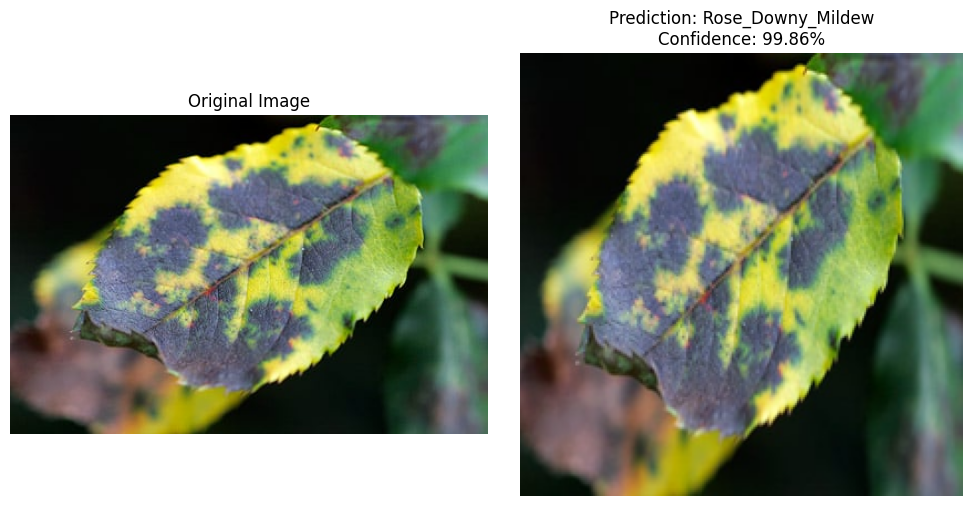


Top 3 Predictions:
--------------------------------------------------
1. Rose_Downy_Mildew: 99.86%
2. Rose_Black_Spot: 0.14%
3. Rose_Mosaic_Virus: 0.00%


In [27]:
model = tf.keras.models.load_model(f'{Config.OUTPUT_DIR}/models/{Config.MODEL_NAME}_final.keras')

# Get class names from your training directory
class_names = sorted(os.listdir(Config.TRAIN_DIR))

# Test with an image URL
image_url = "https://www.rhs.org.uk/getmedia/C141277B-F425-4550-B335-A2D53C657E12/PUB0004498_920494"
prediction, confidence, img = test_image_from_url(
    model=model,
    url=image_url,
    class_names=class_names,
    img_size=Config.IMG_SIZE
)